In [ ]:
!pip install geopy requests folium

# Parte 1: Geocoding com Nominatim (via Geopy)

In [ ]:
import time
from geopy.geocoders import Nominatim

# É fundamental definir um user_agent único para o seu aplicativo
geolocator = Nominatim(user_agent="magalu_2025")

# Endereços que queremos encontrar
endereco_origem = "Recife, PE"
endereco_destino = "Rio de Janeiro, RJ"

# --- Geocoding da Origem ---
location_origem = geolocator.geocode(endereco_origem)
coords_origem = (location_origem.latitude, location_origem.longitude)

# Respeitando a política de uso (1 requisição por segundo)
time.sleep(1)

# --- Geocoding do Destino ---
location_destino = geolocator.geocode(endereco_destino)
coords_destino = (location_destino.latitude, location_destino.longitude)


print(f"--- Origem Encontrada ---")
print(f"Local: {location_origem.address}")
print(f"Coordenadas (Lat, Lng): {coords_origem}\n")

print(f"--- Destino Encontrado ---")
print(f"Local: {location_destino.address}")
print(f"Coordenadas (Lat, Lng): {coords_destino}")

--- Origem Encontrada ---
Local: Recife, Região Geográfica Imediata do Recife, Região Metropolitana do Recife, Região Geográfica Intermediária do Recife, Pernambuco, Região Nordeste, Brasil
Coordenadas (Lat, Lng): (-8.0584933, -34.8848193)

--- Destino Encontrado ---
Local: Rio de Janeiro, Região Geográfica Imediata do Rio de Janeiro, Região Metropolitana do Rio de Janeiro, Região Geográfica Intermediária do Rio de Janeiro, Rio de Janeiro, Região Sudeste, Brasil
Coordenadas (Lat, Lng): (-22.9110137, -43.2093727)


# Parte 2: Roteamento com OSRM (Open Source Routing Machine)

In [ ]:
import requests

# Extrai as coordenadas para a URL
lat_origem, lon_origem = coords_origem
lat_destino, lon_destino = coords_destino

# Monta a URL da API do OSRM
# O formato é {servidor}/route/v1/driving/{lon1},{lat1};{lon2},{lat2}
url = f"http://router.project-osrm.org/route/v1/driving/{lon_origem},{lat_origem};{lon_destino},{lat_destino}?overview=full&geometries=geojson"

# Faz a requisição
response = requests.get(url)
data = response.json()

if 'routes' in data:
    # Extrai os dados da rota
    rota = data['routes'][0]
    distancia_km = rota['distance'] / 1000
    duracao_horas = rota['duration'] / 60 / 60

    # A geometria já vem no formato GeoJSON, perfeito para o Folium!
    rota_geometria = rota['geometry']

    print("--- Rota Calculada ---")
    print(f"Distância: {distancia_km:.2f} km")
    print(f"Duração: {duracao_horas:.2f} horas")
else:
    print(f"Não foi possível encontrar uma rota. Erro: {data.get('message')}")

--- Rota Calculada ---
Distância: 2310.84 km
Duração: 34.15 horas


# Parte 3: Visualização com Folium (Mapa Interativo!)

In [ ]:
import folium

# Calcula um ponto central para iniciar o mapa
centro_mapa = [(lat_origem + lat_destino) / 2, (lon_origem + lon_destino) / 2]

# Cria o objeto do mapa
m = folium.Map(location=centro_mapa, zoom_start=13)

# Adiciona a linha da rota ao mapa
# O Folium entende GeoJSON diretamente
folium.GeoJson(
    rota_geometria,
    style_function=lambda feature: {
        'color': 'blue',
        'weight': 5,
        'opacity': 0.7,
    }
).add_to(m)

# Adiciona marcadores para o início e o fim
folium.Marker(
    location=[lat_origem, lon_origem],
    popup=f"<b>Início:</b><br>{endereco_origem}",
    icon=folium.Icon(color='green', icon='play')
).add_to(m)

folium.Marker(
    location=[lat_destino, lon_destino],
    popup=f"<b>Fim:</b><br>{endereco_destino}",
    icon=folium.Icon(color='red', icon='stop')
).add_to(m)

# Ajusta o zoom do mapa para mostrar a rota inteira
m.fit_bounds(folium.GeoJson(rota_geometria).get_bounds())


# Exibe o mapa interativo
m

In [ ]:
# Lista de rotas que queremos calcular e exibir
rotas_a_calcular = [
    {
        "origem": "Museu do Amanhã, Rio de Janeiro, RJ",
        "destino": "Estádio do Maracanã, Rio de Janeiro, RJ",
        "cor": "blue"
    },
    {
        "origem": "Copacabana Palace, Rio de Janeiro, RJ",
        "destino": "Pão de Açúcar, Rio de Janeiro, RJ",
        "cor": "green"
    },
    {
        "origem": "Jardim Botânico, Rio de Janeiro, RJ",
        "destino": "Cristo Redentor, Rio de Janeiro, RJ",
        "cor": "purple"
    },
    {
        "origem": "Aeroporto Santos Dumont, Rio de Janeiro",
        "destino": "Barra da Tijuca, Rio de Janeiro",
        "cor": "orange"
    }
]

In [ ]:
import folium
import requests
import time
from geopy.geocoders import Nominatim
import pandas as pd

# --- CONFIGURAÇÃO INICIAL ---
geolocator = Nominatim(user_agent="meu_tutorial_jupyter_excel_v1")
mapa_multi_rotas = folium.Map(location=[-22.913, -43.444], zoom_start=12)

# Lista para armazenar os dados para a planilha
resultados_planilha = []

print("Iniciando cálculo das rotas...")

# --- LOOP PELAS ROTAS ---
for i, rota_info in enumerate(rotas_a_calcular):
    print(f"\nProcessando Rota {i+1} de {len(rotas_a_calcular)}...")

    try:
        # 1. GEOCODIFICAÇÃO
        print(f"  Geocodificando: '{rota_info['origem']}' -> '{rota_info['destino']}'")
        location_origem = geolocator.geocode(rota_info['origem'])
        coords_origem = (location_origem.latitude, location_origem.longitude)
        time.sleep(1)

        location_destino = geolocator.geocode(rota_info['destino'])
        coords_destino = (location_destino.latitude, location_destino.longitude)
        time.sleep(1)

        # 2. CÁLCULO DA ROTA (OSRM)
        lat_origem, lon_origem = coords_origem
        lat_destino, lon_destino = coords_destino

        url = f"http://router.project-osrm.org/route/v1/driving/{lon_origem},{lat_origem};{lon_destino},{lat_destino}?overview=full&geometries=geojson"
        response = requests.get(url)
        data = response.json()

        if 'routes' in data:
            rota = data['routes'][0]
            distancia_km = round(rota['distance'] / 1000, 2)
            duracao_min = round(rota['duration'] / 60, 2)
            rota_geometria = rota['geometry']

            # Adiciona os resultados à lista para a planilha
            resultados_planilha.append({
                'Rota': f"Rota {i+1}",
                'Origem': rota_info['origem'],
                'Destino': rota_info['destino'],
                'Distância (km)': distancia_km,
                'Tempo (minutos)': duracao_min
            })

            # 3. ADICIONANDO ELEMENTOS AO MAPA
            folium.GeoJson(
                rota_geometria,
                style_function=lambda feature, color=rota_info['cor']: {'color': color, 'weight': 5, 'opacity': 0.8}
            ).add_to(mapa_multi_rotas)

            folium.Marker(
                location=[lat_origem, lon_origem],
                popup=f"<b>Origem {i+1}</b>",
                icon=folium.Icon(color=rota_info['cor'], icon='play')
            ).add_to(mapa_multi_rotas)

            folium.Marker(
                location=[lat_destino, lon_destino],
                popup=f"<b>Destino {i+1}</b>",
                icon=folium.Icon(color=rota_info['cor'], icon='stop')
            ).add_to(mapa_multi_rotas)

            print(f"  Rota {i+1} adicionada com sucesso! Distância: {distancia_km} km, Tempo: {duracao_min} min.")
        else:
            print(f"  Não foi possível encontrar a Rota {i+1}.")
    except Exception as e:
        print(f"  Ocorreu um erro ao processar a Rota {i+1}: {e}")

# --- CRIAÇÃO DA PLANILHA EXCEL ---
if resultados_planilha:
    print("\nGerando planilha Excel com os resultados...")
    df = pd.DataFrame(resultados_planilha)

    # Salva o DataFrame em um arquivo .xlsx
    nome_arquivo_excel = 'relatorio_rotas.xlsx'
    df.to_excel(nome_arquivo_excel, index=False, engine='openpyxl')

    print(f"Planilha '{nome_arquivo_excel}' criada com sucesso!")
else:
    print("\nNenhuma rota foi calculada com sucesso. A planilha não foi gerada.")

# Ajusta o zoom do mapa e o exibe
mapa_multi_rotas.fit_bounds(mapa_multi_rotas.get_bounds())
mapa_multi_rotas

# Código para Análise Comparativa (Recife vs. Salvador)

In [ ]:
import folium
import requests
import time
from geopy.geocoders import Nominatim
import pandas as pd
from IPython.display import display

# --- PASSO 1: DEFINIR OS PARÂMETROS DA ANÁLISE ---

# Lista das principais capitais destino para a análise
capitais_destino = [
    "São Paulo, SP",
    "Rio de Janeiro, RJ",
    "Belo Horizonte, MG",
    "Brasília, DF",
    "Fortaleza, CE",
    "Manaus, AM",
    "Belém, PA",
    "Porto Alegre, RS",
    "Curitiba, PR",
    "Goiânia, GO"
]

# Cidades candidatas a se tornarem o Centro de Distribuição
cds_candidatos = {
    "Recife": "Recife, PE",
    "Salvador": "Salvador, BA"
}

# --- PASSO 2: FUNÇÃO PARA GERAR A ANÁLISE COMPLETA ---

def gerar_analise_cd(cidade_cd_nome, cidade_cd_endereco, destinos):
    """
    Calcula rotas, gera um mapa e um relatório em Excel para um CD candidato.
    """
    print(f"\n{'='*40}")
    print(f"INICIANDO ANÁLISE PARA O CD EM: {cidade_cd_nome.upper()}")
    print(f"{'='*40}")

    geolocator = Nominatim(user_agent=f"analise_cd_magalu_{cidade_cd_nome.lower()}_v1")
    mapa = folium.Map(location=[-15.788, -47.879], zoom_start=4) # Centralizado no Brasil
    resultados_planilha = []

    try:
        # Geocodifica o CD uma única vez
        print(f"Localizando o CD em {cidade_cd_nome}...")
        location_cd = geolocator.geocode(cidade_cd_endereco)
        coords_cd = (location_cd.latitude, location_cd.longitude)
        time.sleep(1)

        # Adiciona marcador para o CD
        folium.Marker(
            location=coords_cd,
            popup=f"<b>CD {cidade_cd_nome}</b>",
            icon=folium.Icon(color='red', icon_size=(35,35), icon='star')
        ).add_to(mapa)

        # Loop pelos destinos
        for destino_nome in destinos:
            try:
                print(f"  Calculando rota para: {destino_nome}...")
                location_destino = geolocator.geocode(destino_nome)
                coords_destino = (location_destino.latitude, location_destino.longitude)
                time.sleep(1)

                url = f"http://router.project-osrm.org/route/v1/driving/{coords_cd[1]},{coords_cd[0]};{location_destino.longitude},{location_destino.latitude}?overview=full&geometries=geojson"
                response = requests.get(url)
                data = response.json()

                if 'routes' in data:
                    rota = data['routes'][0]
                    distancia_km = round(rota['distance'] / 1000, 2)
                    duracao_horas = round(rota['duration'] / 3600, 2) # Convertendo para horas

                    resultados_planilha.append({
                        'CD de Origem': cidade_cd_nome,
                        'Capital Destino': destino_nome,
                        'Distância (km)': distancia_km,
                        'Tempo de Viagem (horas)': duracao_horas
                    })

                    folium.GeoJson(
                        rota['geometry'],
                        style_function=lambda feature: {'color': 'blue', 'weight': 3, 'opacity': 0.7}
                    ).add_to(mapa)
                    folium.Marker(
                        location=coords_destino,
                        popup=destino_nome,
                        icon=folium.Icon(color='blue', icon='truck', prefix='fa')
                    ).add_to(mapa)
                else:
                     print(f"    -> AVISO: Não foi possível encontrar rota para {destino_nome}.")

            except Exception as e:
                print(f"    -> ERRO ao processar o destino {destino_nome}: {e}")

        # --- GERAÇÃO DOS ARQUIVOS DE RESULTADO ---
        if resultados_planilha:
            df = pd.DataFrame(resultados_planilha)

            # Calcula totais e médias
            distancia_total = df['Distância (km)'].sum()
            tempo_total = df['Tempo de Viagem (horas)'].sum()
            distancia_media = df['Distância (km)'].mean()
            tempo_medio = df['Tempo de Viagem (horas)'].mean()

            # Adiciona as métricas ao DataFrame
            df_sumario = pd.DataFrame([
                {'Capital Destino': '---', 'Distância (km)': '---', 'Tempo de Viagem (horas)': '---'},
                {'Capital Destino': '**TOTAL**', 'Distância (km)': round(distancia_total, 2), 'Tempo de Viagem (horas)': round(tempo_total, 2)},
                {'Capital Destino': '**MÉDIA**', 'Distância (km)': round(distancia_media, 2), 'Tempo de Viagem (horas)': round(tempo_medio, 2)}
            ])
            df_final = pd.concat([df, df_sumario], ignore_index=True)

            # Salva arquivos
            nome_mapa = f'mapa_rotas_{cidade_cd_nome.lower()}.html'
            nome_excel = f'relatorio_{cidade_cd_nome.lower()}.xlsx'
            mapa.save(nome_mapa)
            df_final.to_excel(nome_excel, index=False, engine='openpyxl')

            print(f"\nANÁLISE PARA {cidade_cd_nome.upper()} CONCLUÍDA!")
            print(f" -> Mapa salvo em: {nome_mapa}")
            print(f" -> Relatório salvo em: {nome_excel}")

            display(df_final) # Mostra a tabela no notebook
        else:
            print("Nenhuma rota foi calculada. Arquivos não gerados.")

    except Exception as e:
        print(f"ERRO GERAL na análise de {cidade_cd_nome}: {e}")

# --- PASSO 3: EXECUTAR A ANÁLISE PARA CADA CANDIDATO ---
for nome, endereco in cds_candidatos.items():
    gerar_analise_cd(nome, endereco, capitais_destino)


INICIANDO ANÁLISE PARA O CD EM: RECIFE
Localizando o CD em Recife...
  Calculando rota para: São Paulo, SP...
  Calculando rota para: Rio de Janeiro, RJ...
  Calculando rota para: Belo Horizonte, MG...
  Calculando rota para: Brasília, DF...
  Calculando rota para: Fortaleza, CE...
  Calculando rota para: Manaus, AM...
  Calculando rota para: Belém, PA...
  Calculando rota para: Porto Alegre, RS...
  Calculando rota para: Curitiba, PR...
  Calculando rota para: Goiânia, GO...

ANÁLISE PARA RECIFE CONCLUÍDA!
 -> Mapa salvo em: mapa_rotas_recife.html
 -> Relatório salvo em: relatorio_recife.xlsx


,CD de Origem,Capital Destino,Distância (km),Tempo de Viagem (horas)
0,Recife,"São Paulo, SP",2636.91,36.44
1,Recife,"Rio de Janeiro, RJ",2310.84,34.15
2,Recife,"Belo Horizonte, MG",2076.84,28.98
3,Recife,"Brasília, DF",2143.85,29.34
4,Recife,"Fortaleza, CE",802.97,11.38
5,Recife,"Manaus, AM",4653.44,79.11
6,Recife,"Belém, PA",2025.41,26.85
7,Recife,"Porto Alegre, RS",3758.08,50.9
8,Recife,"Curitiba, PR",3030.9,41.88
9,Recife,"Goiânia, GO",2344.5,32.18



INICIANDO ANÁLISE PARA O CD EM: SALVADOR
Localizando o CD em Salvador...
  Calculando rota para: São Paulo, SP...
  Calculando rota para: Rio de Janeiro, RJ...
  Calculando rota para: Belo Horizonte, MG...
  Calculando rota para: Brasília, DF...
  Calculando rota para: Fortaleza, CE...
  Calculando rota para: Manaus, AM...
  Calculando rota para: Belém, PA...
  Calculando rota para: Porto Alegre, RS...
  Calculando rota para: Curitiba, PR...
  Calculando rota para: Goiânia, GO...

ANÁLISE PARA SALVADOR CONCLUÍDA!
 -> Mapa salvo em: mapa_rotas_salvador.html
 -> Relatório salvo em: relatorio_salvador.xlsx


,CD de Origem,Capital Destino,Distância (km),Tempo de Viagem (horas)
0,Salvador,"São Paulo, SP",1960.75,26.96
1,Salvador,"Rio de Janeiro, RJ",1634.68,24.67
2,Salvador,"Belo Horizonte, MG",1400.68,19.5
3,Salvador,"Brasília, DF",1467.69,19.86
4,Salvador,"Fortaleza, CE",1183.7,17.91
5,Salvador,"Manaus, AM",4936.37,77.21
6,Salvador,"Belém, PA",2046.69,28.46
7,Salvador,"Porto Alegre, RS",3081.92,41.42
8,Salvador,"Curitiba, PR",2354.74,32.4
9,Salvador,"Goiânia, GO",1668.33,22.7


# Executando a Análise de Malha Viária Regional (Nordeste)

In [ ]:
import folium
import requests
import time
from geopy.geocoders import Nominatim
import pandas as pd
from IPython.display import display

# --- PASSO 1: DEFINIR OS PARÂMETROS DA ANÁLISE REGIONAL ---

# Lista das capitais-destino na região Nordeste
capitais_nordeste = [
    "Fortaleza, CE",
    "São Luís, MA",
    "Teresina, PI",
    "Natal, RN",
    "João Pessoa, PB",
    "Maceió, AL",
    "Aracaju, SE"
]

# Cidades candidatas a se tornarem o Centro de Distribuição
cds_candidatos = {
    "Recife": "Recife, PE",
    "Salvador": "Salvador, BA"
}

# --- PASSO 2: REUTILIZAR A FUNÇÃO DE ANÁLISE ---

def gerar_analise_cd(cidade_cd_nome, cidade_cd_endereco, destinos):
    """
    Calcula rotas, gera um mapa e um relatório em Excel para um CD candidato.
    """
    print(f"\n{'='*50}")
    print(f"INICIANDO ANÁLISE REGIONAL PARA O CD EM: {cidade_cd_nome.upper()}")
    print(f"{'='*50}")

    geolocator = Nominatim(user_agent=f"analise_cd_magalu_regional_{cidade_cd_nome.lower()}_v1")
    mapa = folium.Map(location=[-9.9, -41.3], zoom_start=5) # Centralizado no Nordeste
    resultados_planilha = []

    try:
        # Geocodifica o CD uma única vez
        print(f"Localizando o CD em {cidade_cd_nome}...")
        location_cd = geolocator.geocode(cidade_cd_endereco)
        coords_cd = (location_cd.latitude, location_cd.longitude)
        time.sleep(1)

        folium.Marker(
            location=coords_cd,
            popup=f"<b>CD {cidade_cd_nome}</b>",
            icon=folium.Icon(color='red', icon_size=(35,35), icon='star')
        ).add_to(mapa)

        # Loop pelos destinos
        for destino_nome in destinos:
            # Garante que a origem não seja a mesma que o destino
            if cidade_cd_nome.lower() in destino_nome.lower():
                continue

            try:
                print(f"  Calculando rota para: {destino_nome}...")
                location_destino = geolocator.geocode(destino_nome)
                coords_destino = (location_destino.latitude, location_destino.longitude)
                time.sleep(1)

                url = f"http://router.project-osrm.org/route/v1/driving/{coords_cd[1]},{coords_cd[0]};{location_destino.longitude},{location_destino.latitude}?overview=full&geometries=geojson"
                response = requests.get(url)
                data = response.json()

                if 'routes' in data:
                    rota = data['routes'][0]
                    distancia_km = round(rota['distance'] / 1000, 2)
                    duracao_horas = round(rota['duration'] / 3600, 2)

                    resultados_planilha.append({
                        'CD de Origem': cidade_cd_nome,
                        'Capital Destino': destino_nome,
                        'Distância (km)': distancia_km,
                        'Tempo de Viagem (horas)': duracao_horas
                    })

                    folium.GeoJson(
                        rota['geometry'],
                        style_function=lambda feature: {'color': 'green', 'weight': 4, 'opacity': 0.7}
                    ).add_to(mapa)
                    folium.Marker(
                        location=coords_destino,
                        popup=destino_nome,
                        icon=folium.Icon(color='blue', icon='truck', prefix='fa')
                    ).add_to(mapa)
                else:
                     print(f"    -> AVISO: Não foi possível encontrar rota para {destino_nome}.")

            except Exception as e:
                print(f"    -> ERRO ao processar o destino {destino_nome}: {e}")

        # --- GERAÇÃO DOS ARQUIVOS DE RESULTADO ---
        if resultados_planilha:
            df = pd.DataFrame(resultados_planilha)

            distancia_total = df['Distância (km)'].sum()
            tempo_total = df['Tempo de Viagem (horas)'].sum()
            distancia_media = df['Distância (km)'].mean()
            tempo_medio = df['Tempo de Viagem (horas)'].mean()

            df_sumario = pd.DataFrame([
                {'Capital Destino': '---', 'Distância (km)': '---', 'Tempo de Viagem (horas)': '---'},
                {'Capital Destino': '**TOTAL**', 'Distância (km)': round(distancia_total, 2), 'Tempo de Viagem (horas)': round(tempo_total, 2)},
                {'Capital Destino': '**MÉDIA**', 'Distância (km)': round(distancia_media, 2), 'Tempo de Viagem (horas)': round(tempo_medio, 2)}
            ])
            df_final = pd.concat([df, df_sumario], ignore_index=True)

            nome_mapa = f'mapa_rotas_nordeste_{cidade_cd_nome.lower()}.html'
            nome_excel = f'relatorio_nordeste_{cidade_cd_nome.lower()}.xlsx'
            mapa.save(nome_mapa)
            df_final.to_excel(nome_excel, index=False, engine='openpyxl')

            print(f"\nANÁLISE REGIONAL PARA {cidade_cd_nome.upper()} CONCLUÍDA!")
            print(f" -> Mapa salvo em: {nome_mapa}")
            print(f" -> Relatório salvo em: {nome_excel}")

            display(df_final)
        else:
            print("Nenhuma rota foi calculada. Arquivos não gerados.")

    except Exception as e:
        print(f"ERRO GERAL na análise de {cidade_cd_nome}: {e}")

# --- PASSO 3: EXECUTAR A ANÁLISE REGIONAL PARA CADA CANDIDATO ---
for nome, endereco in cds_candidatos.items():
    # Ajusta a lista de destinos para não incluir a própria capital do CD
    destinos_regionais = [cap for cap in capitais_nordeste if nome.lower() not in cap.lower()]
    gerar_analise_cd(nome, endereco, destinos_regionais)


INICIANDO ANÁLISE REGIONAL PARA O CD EM: RECIFE
Localizando o CD em Recife...
  Calculando rota para: Fortaleza, CE...
  Calculando rota para: São Luís, MA...
  Calculando rota para: Teresina, PI...
  Calculando rota para: Natal, RN...
  Calculando rota para: João Pessoa, PB...
  Calculando rota para: Maceió, AL...
  Calculando rota para: Aracaju, SE...

ANÁLISE REGIONAL PARA RECIFE CONCLUÍDA!
 -> Mapa salvo em: mapa_rotas_nordeste_recife.html
 -> Relatório salvo em: relatorio_nordeste_recife.xlsx


,CD de Origem,Capital Destino,Distância (km),Tempo de Viagem (horas)
0,Recife,"Fortaleza, CE",802.97,11.38
1,Recife,"São Luís, MA",1554.86,20.41
2,Recife,"Teresina, PI",1124.76,13.92
3,Recife,"Natal, RN",284.7,4.04
4,Recife,"João Pessoa, PB",116.58,1.78
5,Recife,"Maceió, AL",254.36,3.53
6,Recife,"Aracaju, SE",495.74,6.71
7,NaN,---,---,---
8,NaN,**TOTAL**,4633.97,61.77
9,NaN,**MÉDIA**,662.0,8.82



INICIANDO ANÁLISE REGIONAL PARA O CD EM: SALVADOR
Localizando o CD em Salvador...
  Calculando rota para: Fortaleza, CE...
  Calculando rota para: São Luís, MA...
  Calculando rota para: Teresina, PI...
  Calculando rota para: Natal, RN...
  Calculando rota para: João Pessoa, PB...
  Calculando rota para: Maceió, AL...
  Calculando rota para: Aracaju, SE...

ANÁLISE REGIONAL PARA SALVADOR CONCLUÍDA!
 -> Mapa salvo em: mapa_rotas_nordeste_salvador.html
 -> Relatório salvo em: relatorio_nordeste_salvador.xlsx


,CD de Origem,Capital Destino,Distância (km),Tempo de Viagem (horas)
0,Salvador,"Fortaleza, CE",1183.7,17.91
1,Salvador,"São Luís, MA",1576.14,22.02
2,Salvador,"Teresina, PI",1146.04,15.53
3,Salvador,"Natal, RN",1082.46,14.7
4,Salvador,"João Pessoa, PB",914.34,12.44
5,Salvador,"Maceió, AL",575.96,7.86
6,Salvador,"Aracaju, SE",317.95,4.29
7,NaN,---,---,---
8,NaN,**TOTAL**,6796.59,94.75
9,NaN,**MÉDIA**,970.94,13.54


# Gerando os Gráficos Comparativos

/tmp/ipython-input-3219442767.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Cidade', y='Tempo de Viagem (horas)', data=dados_plot[dados_plot['Análise'] == 'Nacional'], palette=['#007bff', '#ffc107'])
/tmp/ipython-input-3219442767.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='Cidade', y='Tempo de Viagem (horas)', data=dados_plot[dados_plot['Análise'] == 'Regional (Nordeste)'], palette=['#007bff', '#ffc107'])


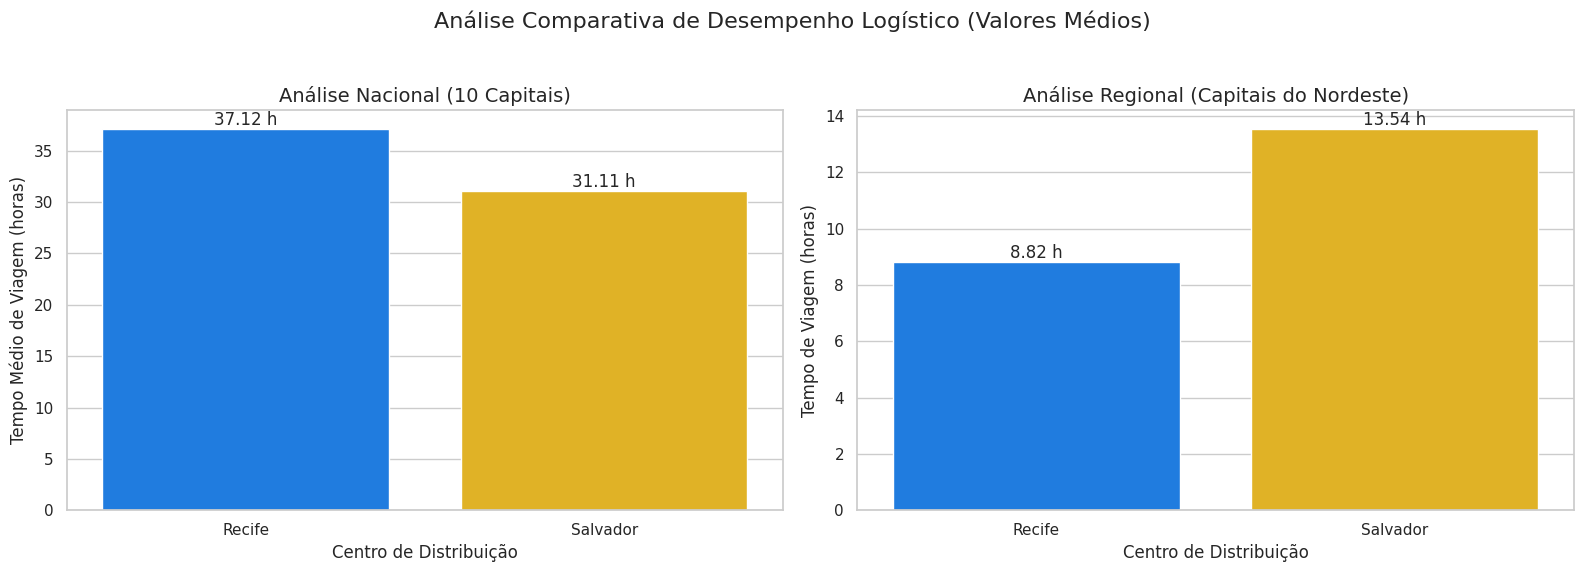


Tabela de Dados Utilizada para os Gráficos:


,Análise,Cidade,Distância Média (km),Tempo de Viagem (horas)
0,Nacional,Recife,2578.37,37.12
1,Nacional,Salvador,2173.56,31.11
2,Regional (Nordeste),Recife,662.00,8.82
3,Regional (Nordeste),Salvador,970.94,13.54


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define um estilo visual mais agradável para os gráficos
sns.set_theme(style="whitegrid")

# --- PASSO 1: Carregar os dados dos relatórios ---

try:
    # Análise Nacional (Nomes de arquivos corrigidos para minúsculas)
    df_nacional_recife = pd.read_excel('relatorio_recife.xlsx')
    df_nacional_salvador = pd.read_excel('relatorio_salvador.xlsx')

    # Análise Regional (Nordeste) (Nomes de arquivos corrigidos para minúsculas)
    df_regional_recife = pd.read_excel('relatorio_nordeste_recife.xlsx')
    df_regional_salvador = pd.read_excel('relatorio_nordeste_salvador.xlsx')

    # --- PASSO 2: Extrair as métricas de MÉDIA de cada relatório ---

    media_nacional_recife = df_nacional_recife[df_nacional_recife['Capital Destino'] == '**MÉDIA**']
    media_nacional_salvador = df_nacional_salvador[df_nacional_salvador['Capital Destino'] == '**MÉDIA**']
    media_regional_recife = df_regional_recife[df_regional_recife['Capital Destino'] == '**MÉDIA**']
    media_regional_salvador = df_regional_salvador[df_regional_salvador['Capital Destino'] == '**MÉDIA**']

    # --- PASSO 3: Criar um DataFrame consolidado para facilitar a plotagem ---

    dados_plot = pd.DataFrame({
        'Análise': ['Nacional', 'Nacional', 'Regional (Nordeste)', 'Regional (Nordeste)'],
        'Cidade': ['Recife', 'Salvador', 'Recife', 'Salvador'],
        'Distância Média (km)': [
            media_nacional_recife['Distância (km)'].iloc[0],
            media_nacional_salvador['Distância (km)'].iloc[0],
            media_regional_recife['Distância (km)'].iloc[0],
            media_regional_salvador['Distância (km)'].iloc[0]
        ],
        'Tempo de Viagem (horas)': [
            media_nacional_recife['Tempo de Viagem (horas)'].iloc[0],
            media_nacional_salvador['Tempo de Viagem (horas)'].iloc[0],
            media_regional_recife['Tempo de Viagem (horas)'].iloc[0],
            media_regional_salvador['Tempo de Viagem (horas)'].iloc[0]
        ]
    })

    # --- PASSO 4: Gerar e exibir os gráficos ---

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Análise Comparativa de Desempenho Logístico (Valores Médios)', fontsize=16)

    sns.barplot(ax=axes[0], x='Cidade', y='Tempo de Viagem (horas)', data=dados_plot[dados_plot['Análise'] == 'Nacional'], palette=['#007bff', '#ffc107'])
    axes[0].set_title('Análise Nacional (10 Capitais)', fontsize=14)
    axes[0].set_xlabel('Centro de Distribuição', fontsize=12)
    axes[0].set_ylabel('Tempo Médio de Viagem (horas)', fontsize=12)
    for container in axes[0].containers:
        axes[0].bar_label(container, fmt='%.2f h')

    sns.barplot(ax=axes[1], x='Cidade', y='Tempo de Viagem (horas)', data=dados_plot[dados_plot['Análise'] == 'Regional (Nordeste)'], palette=['#007bff', '#ffc107'])
    axes[1].set_title('Análise Regional (Capitais do Nordeste)', fontsize=14)
    axes[1].set_xlabel('Centro de Distribuição', fontsize=12)
    axes[1].set_ylabel('Tempo de Viagem (horas)', fontsize=12)
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt='%.2f h')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("\nTabela de Dados Utilizada para os Gráficos:")
    display(dados_plot)

except FileNotFoundError as e:
    print(f"ERRO: Arquivo não encontrado. Verifique se os seguintes arquivos existem na sua pasta e se os nomes estão corretos (sem letras maiúsculas):")
    print("- relatorio_recife.xlsx")
    print("- relatorio_salvador.xlsx")
    print("- relatorio_nordeste_recife.xlsx")
    print("- relatorio_nordeste_salvador.xlsx")
    print(f"\nDetalhe do erro: {e}")